<a href="https://colab.research.google.com/github/Nofryantii/202055202008-Nofryanti/blob/master/nofryanti_klasifikasi_kacang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d nofryantiainun/dataset
!mkdir dataset

100% 337M/339M [00:18<00:00, 20.8MB/s]
100% 339M/339M [00:18<00:00, 18.7MB/s]


In [10]:
!unzip /content/dataset.zip -d /content/dataset

Archive:  /content/dataset.zip
  inflating: /content/dataset/dataset/test/almond/a (1).jpg  
  inflating: /content/dataset/dataset/test/almond/a (10).jpg  
  inflating: /content/dataset/dataset/test/almond/a (11).jpg  
  inflating: /content/dataset/dataset/test/almond/a (12).jpg  
  inflating: /content/dataset/dataset/test/almond/a (13).jpg  
  inflating: /content/dataset/dataset/test/almond/a (14).jpg  
  inflating: /content/dataset/dataset/test/almond/a (15).jpg  
  inflating: /content/dataset/dataset/test/almond/a (16).jpg  
  inflating: /content/dataset/dataset/test/almond/a (17).jpg  
  inflating: /content/dataset/dataset/test/almond/a (18).jpg  
  inflating: /content/dataset/dataset/test/almond/a (2).jpg  
  inflating: /content/dataset/dataset/test/almond/a (3).jpg  
  inflating: /content/dataset/dataset/test/almond/a (4).jpg  
  inflating: /content/dataset/dataset/test/almond/a (5).jpg  
  inflating: /content/dataset/dataset/test/almond/a (6).jpg  
  inflating: /content/dataset/

In [11]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [12]:
dataset_path = Path(r'/content/dataset')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [13]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/dataset/dataset/test/almond/a (17).jpg,almond
1,/content/dataset/dataset/test/almond/a (9).jpg,almond
2,/content/dataset/dataset/test/almond/a (7).jpg,almond
3,/content/dataset/dataset/test/almond/a (15).jpg,almond
4,/content/dataset/dataset/test/almond/a (3).jpg,almond


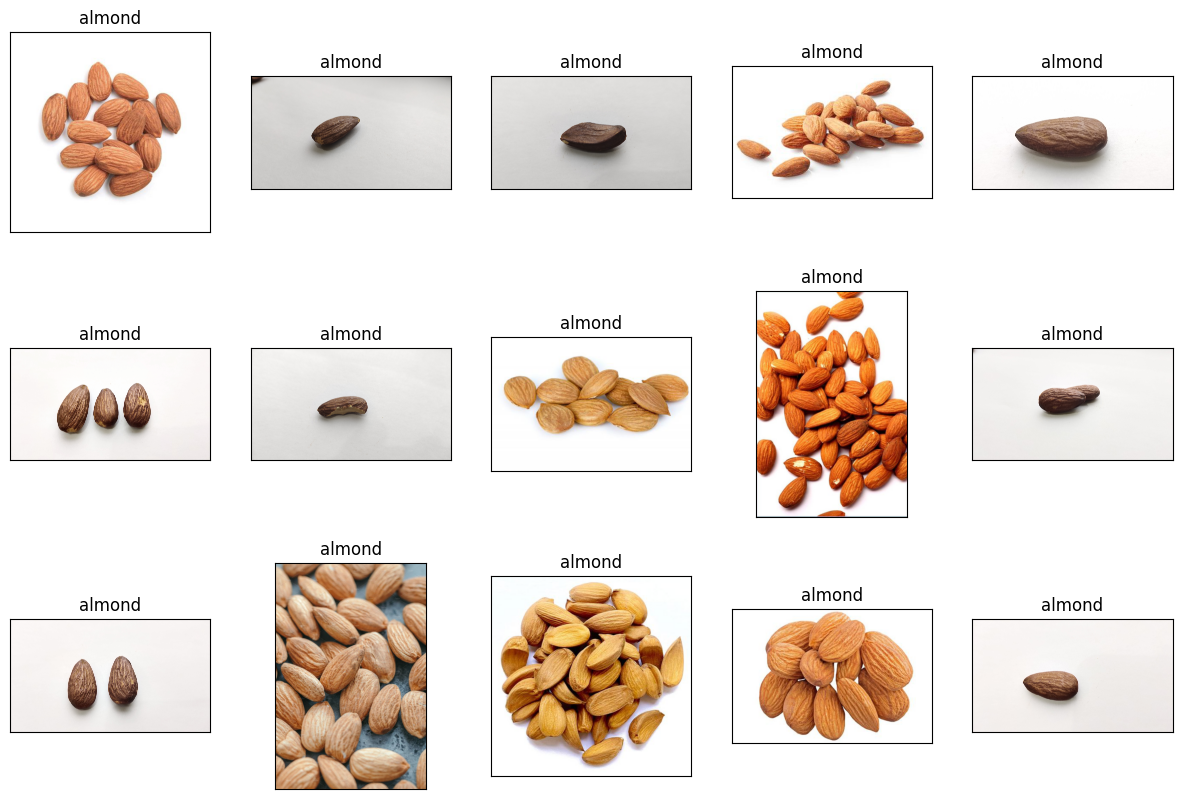

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [15]:
df.label.value_counts()

almond    118
cashew     94
peanut     64
Name: label, dtype: int64

In [16]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

almond    118
cashew     94
peanut     64
Name: label, dtype: int64

In [17]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [18]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (154, 2)
Shape of test data (83, 2)
Shape of validation data (39, 2)


In [19]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 154 validated image filenames belonging to 3 classes.
Found 83 validated image filenames belonging to 3 classes.
Found 39 validated image filenames belonging to 3 classes.


In [20]:
input_shape = (200, 200, 3)

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [22]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 512, validation_data=val, epochs=100, callbacks=callback)

Epoch 1/100
5/5 [==============================] - 34s 4s/step - loss: 1.1112 - accuracy: 0.2987 - val_loss: 1.0671 - val_accuracy: 0.3077
Epoch 2/100
5/5 [==============================] - 20s 4s/step - loss: 1.0960 - accuracy: 0.3831 - val_loss: 1.0304 - val_accuracy: 0.5128
Epoch 3/100
5/5 [==============================] - 20s 4s/step - loss: 1.0818 - accuracy: 0.4091 - val_loss: 1.0534 - val_accuracy: 0.5128
Epoch 4/100
5/5 [==============================] - 20s 4s/step - loss: 1.0800 - accuracy: 0.3701 - val_loss: 1.0181 - val_accuracy: 0.5128
Epoch 5/100
5/5 [==============================] - 19s 4s/step - loss: 1.0552 - accuracy: 0.4416 - val_loss: 0.9933 - val_accuracy: 0.5128
Epoch 6/100
5/5 [==============================] - 21s 4s/step - loss: 1.0527 - accuracy: 0.4091 - val_loss: 0.9957 - val_accuracy: 0.5128
Epoch 7/100
5/5 [==============================] - 19s 4s/step - loss: 1.0433 - accuracy: 0.4675 - val_loss: 1.0127 - val_accuracy: 0.5128
Epoch 8/100
5/5 [==========

In [23]:
model.save('model-1.h5')

In [24]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

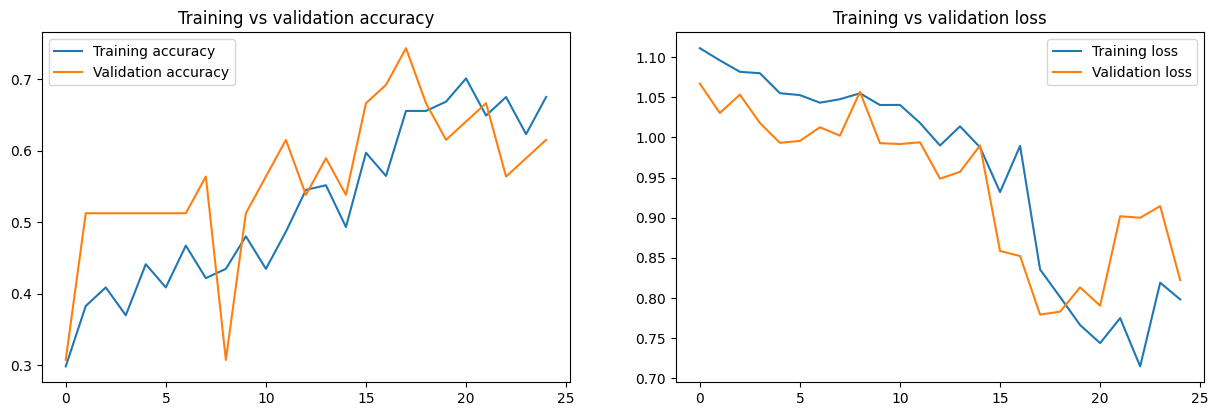

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [26]:
pred = model.predict(test)

3/3 [==============================] - 8s 3s/step


In [27]:
pred = np.argmax(pred, axis=1)

In [28]:
labels = train.class_indices

In [29]:
labels

{'almond': 0, 'cashew': 1, 'peanut': 2}

In [30]:
labels = dict((v,k) for k, v in labels.items())

In [31]:
labels

{0: 'almond', 1: 'cashew', 2: 'peanut'}

In [32]:
y_pred = [labels[k] for k in pred]

In [33]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

      almond       0.62      0.94      0.75        35
      cashew       0.54      0.48      0.51        27
      peanut       0.33      0.10      0.15        21

    accuracy                           0.58        83
   macro avg       0.50      0.51      0.47        83
weighted avg       0.52      0.58      0.52        83



In [34]:
print(confusion_matrix(x_test.label, y_pred))

[[33  0  2]
 [12 13  2]
 [ 8 11  2]]


In [35]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 7s 2s/step - loss: 0.8333 - accuracy: 0.6265
